In [62]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyfolio as pf

/Users/alexlepoidevin/opt/anaconda3/lib/python3.9/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


### Balanced Robust Asset Allocation Strategy: Implementation and Explanation

The Balanced Robust Asset Allocation (BRAA) strategy dynamically adjusts asset allocations to balance risk and return, using recent performance metrics and moving averages to identify potential turning points. Here's a detailed explanation of the strategy and its implementation.

1. **Asset Selection**
2. **Return Calculation**
3. **Allocation Adjustment**
4. **Risk Management**

#### 1. Asset Universe

The portfolio consists of the following assets:

- **MTUM (Momentum)**: Represents stocks with high momentum.
- **IWD (US Large Cap Value)**: Represents US large-cap value stocks.
- **EFA (International Equities)**: Represents developed international equities.
- **EFV (International Value)**: Represents international value stocks.
- **VNQ (REITs)**: Represents real estate investment trusts.
- **DBC (Commodities)**: Represents a diversified commodities index.
- **IEF (US Intermediate Treasuries)**: Represents intermediate-term US Treasury bonds.
- **BIL (Risk-Free Asset)**: Represents short-term Treasury bonds as the risk-free asset.

These assets are chosen to provide diversification across different asset classes and investment styles.

#### 2. Return Calculation

The strategy uses both trailing returns and moving averages to determine allocations. Trailing returns capture the recent performance of an asset, while moving averages help identify trends and potential turning points.

- **Trailing 12-Month Returns** ($ R_{i,t}^{(12)} $):

$ R_{i,t}^{(12)} = \frac{P_{i,t}}{P_{i,t-12}} - 1 $

- **12-Month Moving Average** ($ MA_{i,t}^{(12)} $):

$ MA_{i,t}^{(12)} = \frac{1}{12} \sum_{k=0}^{11} P_{i,t-k} $

Using both metrics allows the strategy to balance momentum with trend-following, reducing exposure to assets that might be nearing a potential turning point.

#### 3. Allocation Adjustment

The allocation for each asset is determined based on its trailing returns and its position relative to its moving average:

- Allocate 100% if both the trailing return is positive and the price is above the moving average.
- Allocate 50% if either the trailing return is positive or the price is above the moving average.
- Allocate 0% if neither condition is met.

Formally:

$ w_{i,t} = \begin{cases} 
1 & \text{if } R_{i,t}^{(12)} > 0 \text{ and } P_{i,t} > MA_{i,t}^{(12)} \\
0.5 & \text{if } R_{i,t}^{(12)} > 0 \text{ or } P_{i,t} > MA_{i,t}^{(12)} \\
0 & \text{otherwise}
\end{cases} $

The unallocated weight is assigned to the risk-free asset (BIL):

$ w_{BIL,t} = 1 - \sum_{i=1}^{N} w_{i,t} $


[*********************100%%**********************]  8 of 8 completed


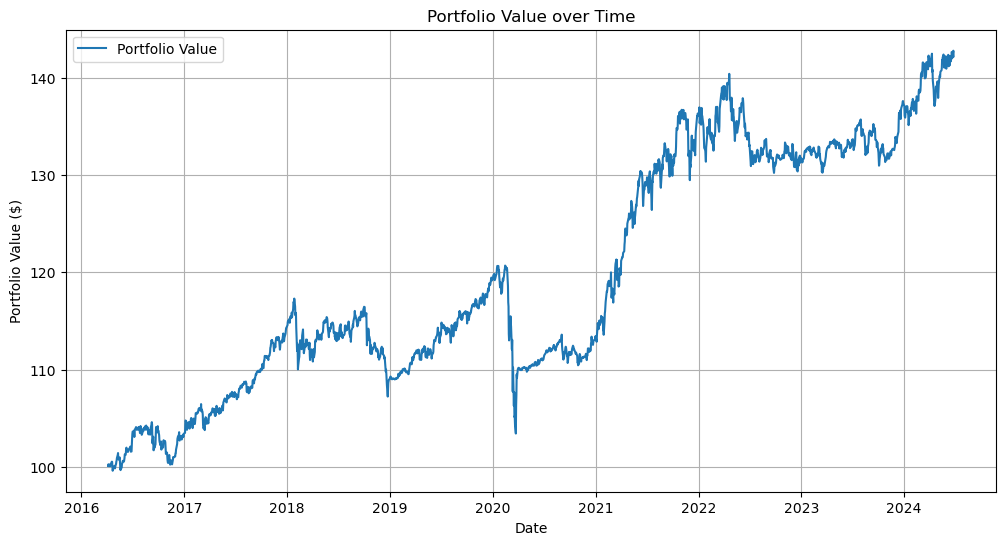

In [41]:
portfolio = {
    'MTUM': 0.1,
    'IWD': 0.1,
    'EFA': 0.10,
    'EFV': 0.1,
    'VNQ': 0.2,
    'DBC': 0.2,
    'IEF': 0.2,
    'BIL': 0.0  
}

data = yf.download(list(portfolio.keys()), start='2015-01-01')['Adj Close']
monthly_data = data.resample('M').last()
trailing_returns_12m = monthly_data.pct_change(periods=12).dropna()
moving_avg_12m = monthly_data.rolling(window=12).mean().dropna()

allocations = pd.DataFrame(index=monthly_data.index, columns=monthly_data.columns)

for asset in portfolio.keys():
    for date in allocations.index:
        if date not in trailing_returns_12m.index or date not in moving_avg_12m.index:
            continue
        if asset == 'BIL':
            allocations.loc[date, asset] = 0.0
        elif trailing_returns_12m.loc[date, asset] > 0 and monthly_data.loc[date, asset] - moving_avg_12m.loc[date, asset] > 0:
            allocations.loc[date, asset] = 1.0
        elif trailing_returns_12m.loc[date, asset] > 0 or monthly_data.loc[date, asset] - moving_avg_12m.loc[date, asset] > 0:
            allocations.loc[date, asset] = 0.5
        else:
            allocations.loc[date, asset] = 0.0

allocations = allocations.fillna(0.0)
portfolio_allocations = allocations.multiply(pd.Series(portfolio), axis=1)
portfolio_allocations['BIL'] = 1.0 - portfolio_allocations.sum(axis=1)
portfolio_allocations_filled = portfolio_allocations.reindex(data.index, method='ffill').fillna(0.0)
combined_data = data.join(portfolio_allocations_filled, rsuffix='_allocation')

daily_returns = data.pct_change().dropna()

allocation_columns = [col for col in combined_data.columns if '_allocation' in col]
allocations = combined_data[allocation_columns]
allocations.columns = [col.replace('_allocation', '') for col in allocations.columns]

weighted_returns = daily_returns * allocations
portfolio_returns = weighted_returns.sum(axis=1)

initial_investment = 100
portfolio_value = (1 + portfolio_returns).cumprod() * initial_investment

plt.figure(figsize=(12, 6))
plt.plot(portfolio_value[315:], label='Portfolio Value')
plt.title('Portfolio Value over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.show()


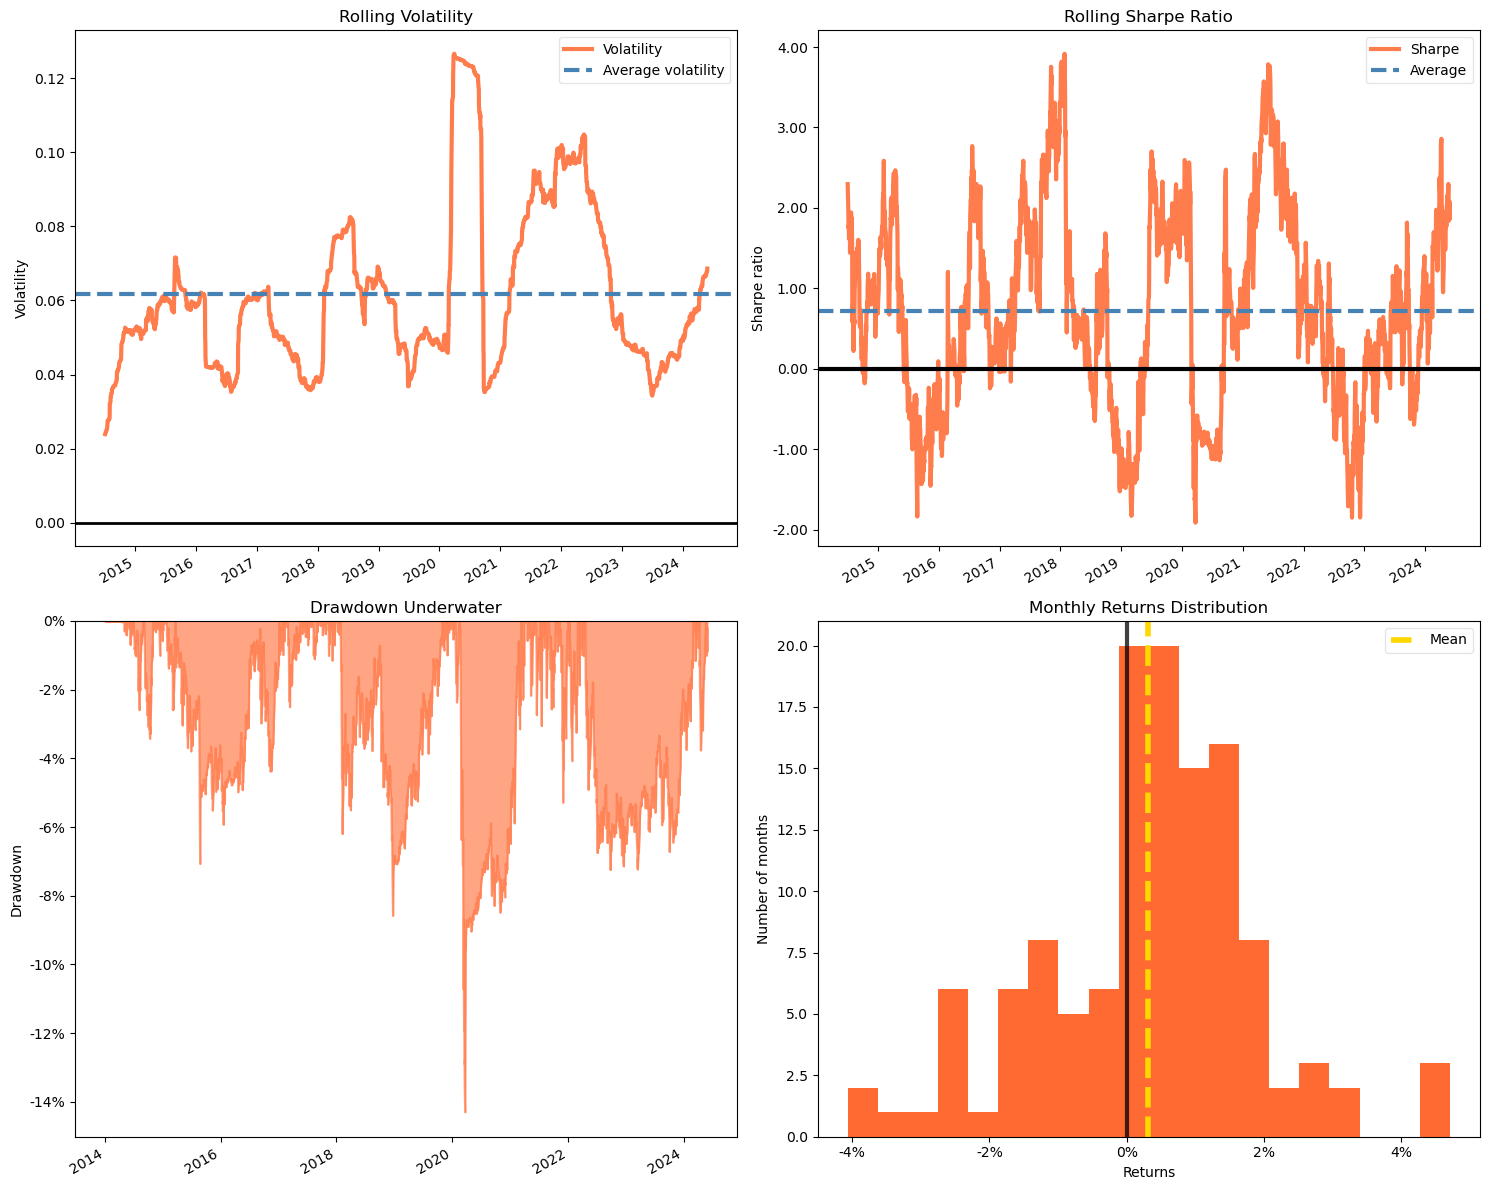

In [88]:
strategy_returns = portfolio_value[252:].pct_change().dropna()
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

plt.sca(axs[0, 0])
pf.plot_rolling_volatility(strategy_returns, ax=axs[0, 0])
axs[0, 0].set_title('Rolling Volatility')

plt.sca(axs[0, 1])
pf.plot_rolling_sharpe(strategy_returns, ax=axs[0, 1])
axs[0, 1].set_title('Rolling Sharpe Ratio')

plt.sca(axs[1, 0])
pf.plot_drawdown_underwater(strategy_returns, ax=axs[1, 0])
axs[1, 0].set_title('Drawdown Underwater')

plt.sca(axs[1, 1])
pf.plot_monthly_returns_dist(strategy_returns, ax=axs[1, 1])
axs[1, 1].set_title('Monthly Returns Distribution')

plt.tight_layout()
plt.show()